# Free surface

In [Boundary Conditions](1.4BoundaryLayers.ipynb), we assumed that the entire domain was surrounded by one of two types of boundary conditions, Cerjan or PML. However, the surface where we collect the seismic data does not really act as absorbing layers. Indeed, free surfaces are more appropriate in this situation and SeisCL must therefore take into account these different layers.

## Theory

When the free surface is chosen by the user, a plane stress free surface is applied at the top of the global grid using the method proposed by [Levander, 1988](10.1190/1.1442422). For modeling a semi-infinite space, the free-surface boundary conditions at $\small z = 0$ is : 

$$
\tau_{z z}=0=\lambda \frac{\partial u}{\partial x}+(\lambda+\mu) \frac{\partial w}{\partial z}
$$
and
$$
\tau_{x z}=0=\mu\left(\frac{\partial u}{\partial z}+\frac{\partial w}{\partial x}\right)
$$

<br>

where $u$ and $w$ are the displacement components in $x$ and $z$, $\tau_{ij}$ are the stresses, $\lambda$ the Lame's parameters and $\mu$ the rigidity. 

## Example


To implement a free surface in SeisCL, the only change necessary from the [Boundary Conditions](1.4BoundaryLayers.ipynb) notebook is to set the parameters <code>freesurf</code> to 1.<br>
We'll then take the same first few lines of code for the initialization.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from SeisCL import SeisCL
seis = SeisCL()


seis.csts['ND'] = 2
seis.csts['N'] = np.array([250, 500])
seis.csts['dt'] = dt = 0.25e-03
seis.csts['dh'] = dh = 2
seis.csts['NT'] = NT = 1500
seis.csts['FDORDER'] = 4
seis.csts['abs_type'] = 1


seis.csts['freesurf'] = 1

In [ ]:
vp = [3500, 2000, 2500]
vs = 2000
rho = 2000
taup = 0
taus = 0

Nz = seis.csts['N'][0]
Nx = seis.csts['N'][1]

seis.csts['nab'] = nab = 15


Thick_vp = [Nz//5, Nz//3]

vp_1 = np.zeros((Thick_vp[0], Nx)) + vp[0]
vp_2 = np.zeros((Thick_vp[1], Nx)) + vp[1]
vp_3 = np.zeros((Nz-np.sum(Thick_vp), Nx)) + vp[2]

vp_all = np.vstack((vp_1, vp_2, vp_3))

vs_all = np.zeros(seis.csts['N']) + vs
rho_all = np.zeros(seis.csts['N']) + rho
taup_all = np.zeros(seis.csts['N']) + taup
taus_all = np.zeros(seis.csts['N']) + taus

Model3Layers = {"vp": vp_all, "rho": rho_all, "vs": vs_all, "taup": taup_all, "taus": taus_all}

Since the upper surface is no longer composed of an absorbent layer, we can position the source and the receivers in a location that is more in line with reality, so closer to the ground.

In [34]:
nbuf = seis.csts['FDORDER'] * 2

sx = (nab + nbuf) * dh
sy = 0
sz = 1 * dh
offmin = 20 * dh
offmax = (Nx - nab - nbuf) * dh - offmin
gx = np.arange(sx + offmin, sx + offmax, 4*dh)
gy = gx * 0
gz = gx * 0 + 1*dh
offset = gx-sx

seis.src_pos_all = np.stack([[sx], [sy], [sz], [0], [2]], axis=0)

gsid = gz * 0
gid = np.arange(0, len(gz))
seis.rec_pos_all = np.stack([gx, gy, gz, gsid, gid, gx * 0 + 2,
                            gx * 0, gx * 0], axis=0)


Let's take a look a our model to make sure everything is as we wanted.

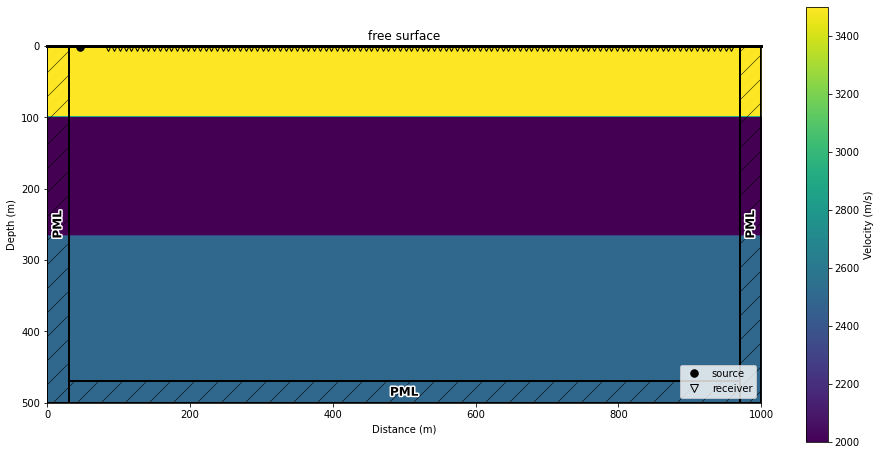

In [35]:
_, ax = plt.subplots(1, 1, figsize = (16,8))
seis.DrawDomain2D(vp_all, ax = ax, ShowAbs = True, ShowSrcRec = True)

Finally, we launch the simulation and show the results.

In [36]:
seis.set_forward(gsid, Model3Layers, withgrad=False)
Info = seis.execute()
data = seis.read_data()
data = data[-1]

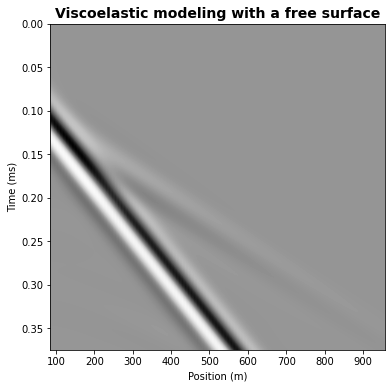

In [40]:
_, ax = plt.subplots(1, 1, figsize=[6, 6])
extent = [min(gx), max(gx), (data.shape[0]-1)*dt, 0]
clip = 1
vmax = np.max(data) * clip
vmin = -vmax
ax.imshow(data, aspect='auto', vmax=vmax, vmin=vmin,
             extent=extent, interpolation='bilinear',
             cmap=plt.get_cmap('Greys'))
ax.set_title("Viscoelastic modeling with a free surface", fontsize=14, fontweight='bold')
ax.set_xlabel("Position (m)")
ax.set_ylabel("Time (ms)")

plt.show()